# Boston

The previous examples were classificaiton problems. Now we'll look at a regression problem.

A regression problem attempts to predict future values for a continuous series of datapoints.

In [31]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data.shape

(404, 13)

The dataset is quite small. The train data only has 404 entries, and each has 13 different **numerical features** such as per capita crime rate, average number of rooms per dwelling etc.

The targets are the median values of owner-occupied homes in 1000s of dollars.

In [2]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

Because the features vary quite a bit in their values it's best practice to do **feature-wise normalisation**.
For each feature in the training data (that is, each row in a column) we'll subtract the mean of the values, and then divide by the standard deviation.
This gives us a feature centered around 0 which has as a unit standard deviation.

In [32]:
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis = 0)
train_data /= std

# Note we don't re-compute mean and std for the test data to ensure we're using the same measurement.
# Never use normalisation based on test data!
test_data -= mean
test_data /= std

Because there are so few examples available we'll use a small network with two hidden layers each with 64 units.

The less data you have, the worse overfitting tends to be, using a small network is one way to mitigate that.

In [33]:
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(
        layers.Dense(
            64,
            activation = 'relu',
            input_shape = (train_data.shape[1],)
        )
    )
    model.add(
        layers.Dense(64, activation = 'relu')
    )
    model.add(layers.Dense(1))
    model.compile(
        optimizer = 'rmsprop',
        loss = 'mse',
        metrics = ['mae']
    )
    return model

The model ends in a single unit with no activaiton (it's a linear layer). This is typical for scalar regression (regression where you're trying to predict a single continuous value).
If we applied an activation that'd constrain the range the output value could take.

We compile with the **mse** los function **mean squared error**. The square of the difference between prediciton and targets. This is widely used for regression problems.

We're also monitoring a new metric **MAE - Mean Absolute Error**. This is the absolute value of the difference between the predicitons and targets.
If the MAE is 0.5 our predictions are off by $500 on average.

## K-fold validation

To evaluate the network during training we will use **K-fold cross-validation**.
Because w ehave such a small amount of training data this will allow us to be a bit more efficient.

We split the data into K partitions (usually 4 or 5), and instantiate K models.
Each model is then trained on K-1 partitions of the data, while evaluating on the remaining portion.
The validaiton score is then the average of the valdiaiton scores obtained between the model instances.

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print(f'Processing fold #{i + 1}/{k}')
    # grab a single chunk for the validation data (from iK to (i + 1)K)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Build a slice from the rest for training by concatenating all chunks before and after the validation chunk.
    partial_train_data = np.concatenate(
        [
            train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]
        ],
        axis = 0
    )
    partial_train_targets = np.concatenate(
        [
            train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]
        ],
        axis = 0
    )
    # Then build and train the model.
    model = build_model()
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data = (val_data, val_targets),
        epochs = num_epochs,
        batch_size = 1,
        verbose = 0
    )
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
print('Done training, averaging MAEs.')
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
print('Done')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


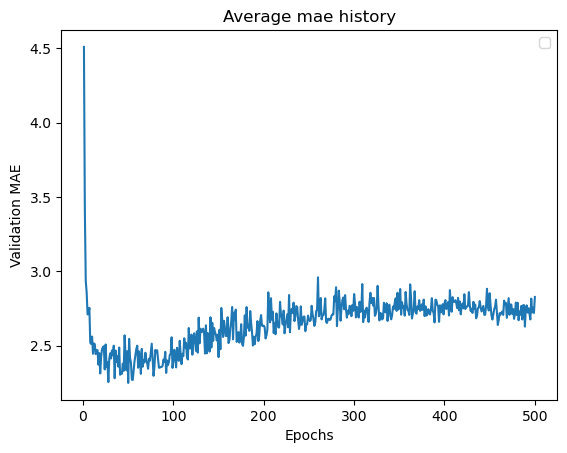

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


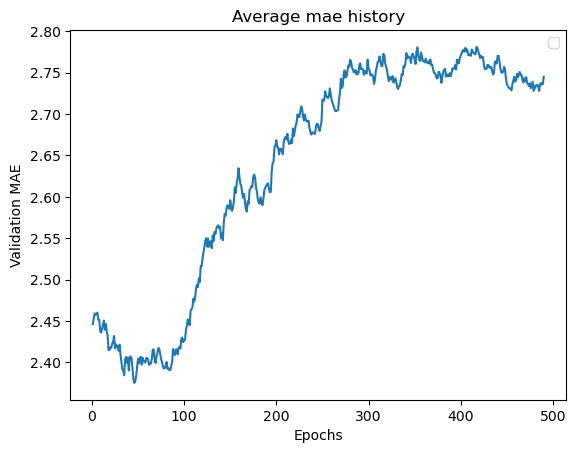

In [28]:
from helpers import *

plot_average_mae_history(average_mae_history)
# As the avriance is high in the beginning we cut out the first 10 data points and smooth our curve to get a better view:
plot_average_mae_history(
    smooth_curve(
        average_mae_history[10:]
    )
)

As we can see, MAE stops improving significantly after about 80 epochs.
Let's retrain a fresh model for that number of epochs.

We'll re-train on the entire dataset this time.

In [37]:
model = build_model()
model.fit(
    train_data,
    train_targets,
    epochs = 80,
    batch_size = 16,
    verbose = 0
)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.5015 - mae: 2.6822


In [40]:
print(f'MSE: {test_mse_score}')
print(f'MAE: ${test_mae_score * 1000}')
print(f'MAE (percent of mean): {round((test_mae_score / test_targets.mean(axis = 0)) * 100, 2)}%')

MSE: 17.50146484375
MAE: $2682.2173595428467
MAE (percent of mean): 11.62%


## Takeaways

- Regression uses different loss function. MSE if often sued.
- Evaluation metrics are different as well. Mean Absolute Error is often use (MAE)
- When input features have different ranges, each feature should be normalised.
- When little data is available, K-fold validation is a great way to more efficiently evaluate the model.
- When little training data is available, a smaller network is better to prevent overfitting.